## Objetivo
Avaliar  a detecção de falha por meio do valor eficaz (RMS) da velocidade segundo norma ABNT

# Níveis gerais de vibração
## Desbalanceamento

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data.csv')
print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 880 
Colunas: 67


In [3]:
def filter_defect(df, condicao):
    # separa apenas amostras com de'feito'
    filtered_df =  df.query("condicao == '{}' or condicao == 'normal'".format(condicao))
    filtered_df.pop('condicao')
    # separa apenas as colunas com RMS da velocidade
    filtered_df = filtered_df[[
        'severidade',   'rotacao_calc', 
         'ax1_vel_rms',  
         'ax2_vel_rms', 
        'rad1_vel_rms', 
        'rad2_vel_rms', 
         'tg1_vel_rms',  
         'tg2_vel_rms' 
    ]]
    # simplifica o nome dos eixos
    filtered_df = filtered_df.rename(columns={
         'ax1_vel_rms': 'ax1',  
         'ax2_vel_rms': 'ax2', 
        'rad1_vel_rms': 'rad1', 
        'rad2_vel_rms': 'rad2', 
         'tg1_vel_rms': 'tg1',  
         'tg2_vel_rms': 'tg2',
         'ax1_rms': 'ax1',  
         'ax2_rms': 'ax2', 
        'rad1_rms': 'rad1', 
        'rad2_rms': 'rad2', 
         'tg1_rms': 'tg1',  
         'tg2_rms': 'tg2',
    })

    return filtered_df

df_desbal = filter_defect(df, 'imbalance')
df_desbal

,severidade,rotacao_calc,ax1,ax2,rad1,rad2,tg1,tg2
498,10.0,13.6,0.290792,0.156689,0.037397,0.032551,0.015765,0.661423
499,10.0,14.2,0.269259,0.161590,0.039777,0.033782,0.019242,0.717941
500,10.0,15.4,0.214419,0.174881,0.037845,0.034818,0.026821,0.548304
501,10.0,16.2,0.193084,0.162101,0.035905,0.031697,0.032707,0.455574
502,10.0,16.8,0.204905,0.136481,0.035404,0.027811,0.041881,0.484378
...,...,...,...,...,...,...,...,...
875,0.0,56.6,0.089921,0.102545,0.080001,0.019883,0.024923,0.145742
876,0.0,57.4,0.089394,0.074770,0.079187,0.015193,0.024222,0.131640
877,0.0,58.2,0.091157,0.061818,0.078539,0.015263,0.024187,0.141584
878,0.0,59.0,0.093749,0.053007,0.076875,0.013435,0.025299,0.147243


In [4]:
VALUE = 'vibração RMS (mm/s²)'
ROTACAO = 'rotação (Hz)'
DESBALANCEAMENTO = 'desbalanceamento (g)'

def select_max(df_filtered):
    # encontra o valor máximo entre todos os RMS
    max_rms = df_filtered.drop(['rotacao_calc', 'severidade'], axis=1).max(axis=1)

    # revela o eixo onde há o maior RMS
    eixo = []
    for i in df_filtered.index:
        for col in df_filtered.columns:
            if df_filtered.loc[i, col] == max_rms[i]:
                eixo.append(col) 

    # cria o novo Dataframe com os máximos
    df_max = df_filtered[['severidade', 'rotacao_calc']].copy()
    df_max.rename(columns={'rotacao_calc': ROTACAO}, inplace=True)
    df_max['eixo'] = eixo
    df_max[VALUE] = max_rms

    return df_max


df_desbal_max = select_max(df_desbal)
df_desbal_max.rename(columns={'severidade': DESBALANCEAMENTO}, inplace=True)

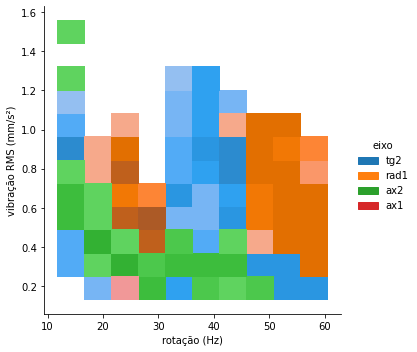

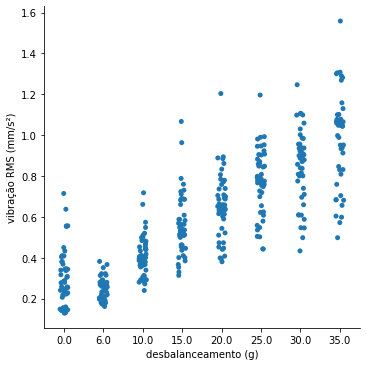

In [5]:
sns.displot(data=df_desbal_max, hue='eixo', y=VALUE, x=ROTACAO);
sns.catplot(data=df_desbal_max, y=VALUE, x=DESBALANCEAMENTO, color='tab:blue');

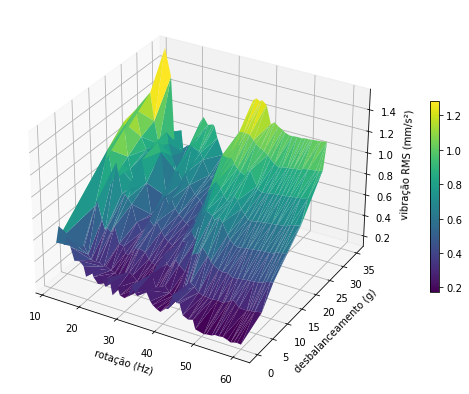

In [6]:
from mpl_toolkits import mplot3d

def plot_surface(df_max, defect_name, fig=None, ax=None):
    # Make the plot

    figura_solo=False

    if ax is None:
        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(projection='3d')
        figura_solo=True

    surf = ax.plot_trisurf(
        df_max[ROTACAO], df_max[defect_name], df_max[VALUE], 
        cmap=plt.cm.viridis, linewidth=0.1
    )
    ax.set_xlabel(ROTACAO)
    ax.set_zlabel(VALUE);

    # to Add a color bar which maps values to colors.
    if figura_solo:
        fig.colorbar(surf, ax=ax, shrink=0.5)
        ax.set_ylabel(defect_name)
    else:
        ax.set_ylabel(defect_name)
        fig.colorbar(surf, ax=ax, shrink=0.2)

plot_surface(df_desbal_max, DESBALANCEAMENTO)

Nível de vibração RMS


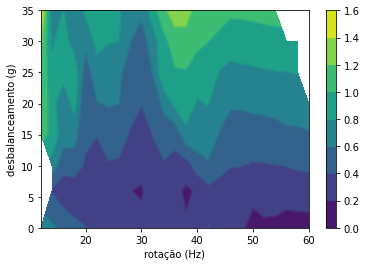

In [7]:
def plota_niveis(df_max, defect_name, fig=None, ax=None):
    df_pivot = df_max.drop(['eixo'], axis=1).copy(deep=True)
    df_pivot[ROTACAO] = df_pivot[ROTACAO].apply(round)//2*2
    df_pivot = df_pivot.groupby([ROTACAO, defect_name]).max()
    df_pivot = df_pivot.reset_index()
    df_pivot = df_pivot.pivot(index=ROTACAO, columns=defect_name, values=VALUE)


    X, Y = np.meshgrid(df_pivot.index, df_pivot.columns)
    Z= df_pivot.T

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
        
    CS = ax.contour(X, Y, Z, levels=8)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp, ax=ax)
    ax.set_xlabel(ROTACAO)
    ax.set_ylabel(defect_name)
    # ax.clabel(CS, inline=1, fontsize=10)
    print('Nível de vibração RMS');

plota_niveis(df_desbal_max, DESBALANCEAMENTO)

Nível de vibração RMS


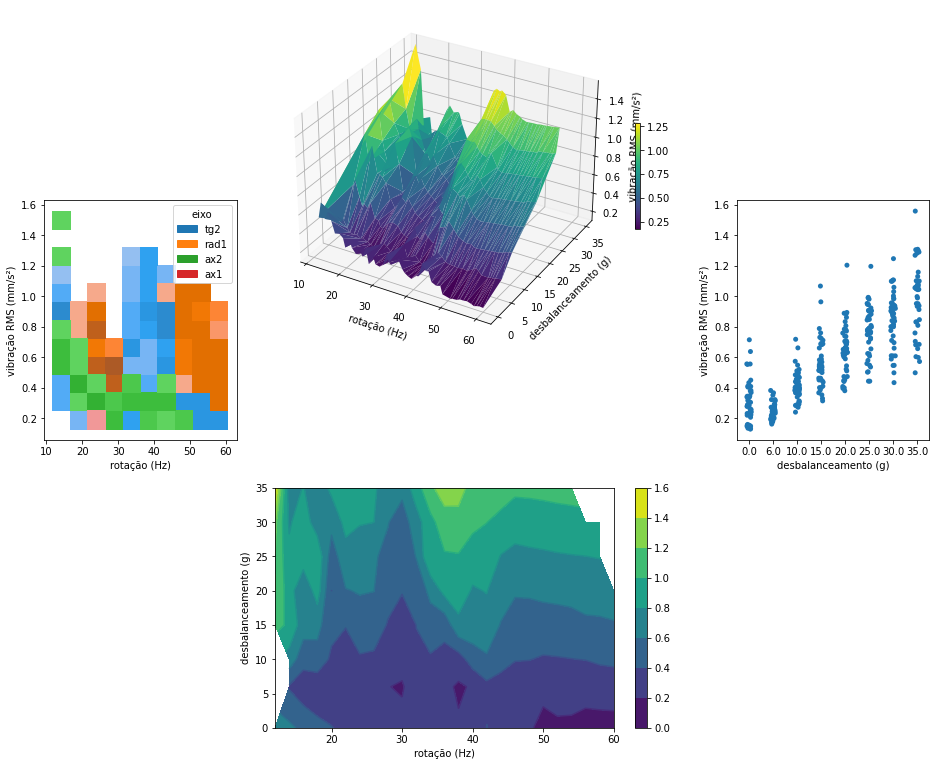

In [8]:
from mpl_toolkits import mplot3d

def plot_conjunto(df_max, defect_name):
    # Make the plot
    fig = plt.figure(figsize=(20,15))

    ax = fig.add_subplot(3, 5, (2,8), projection='3d')
    plot_surface(df_max, defect_name, fig, ax=ax)

    ax = fig.add_subplot(3, 5, 6)
    sns.histplot(data=df_max, hue='eixo', y=VALUE, x=ROTACAO, ax=ax);

    ax = fig.add_subplot(3, 5, 9)
    sns.stripplot(data=df_max, y=VALUE, x=defect_name, color='tab:blue', ax=ax);

    ax = fig.add_subplot(3, 5, (12,13))
    plota_niveis(df_max, defect_name, fig, ax)


plot_conjunto(df_desbal_max, DESBALANCEAMENTO)

# Desalinhamentos

## Vertical

In [9]:
df_des_ver = filter_defect(df, 'vertical-misalignment')
df_des_ver_max = select_max(df_des_ver)

DESALINHAMENTO_VERTICAL = 'desalinhamento vertical (mm)' 
df_des_ver_max.rename(columns={'severidade': DESALINHAMENTO_VERTICAL}, inplace=True)
df_des_ver_max

,desalinhamento vertical (mm),rotação (Hz),eixo,vibração RMS (mm/s²)
197,0.51,12.2,ax2,1.433944
198,0.51,12.8,ax2,1.089130
199,0.51,14.6,ax2,0.830700
200,0.51,15.8,ax2,0.412744
201,0.51,16.6,ax2,0.334960
...,...,...,...,...
875,0.00,56.6,tg2,0.145742
876,0.00,57.4,tg2,0.131640
877,0.00,58.2,tg2,0.141584
878,0.00,59.0,tg2,0.147243


Nível de vibração RMS


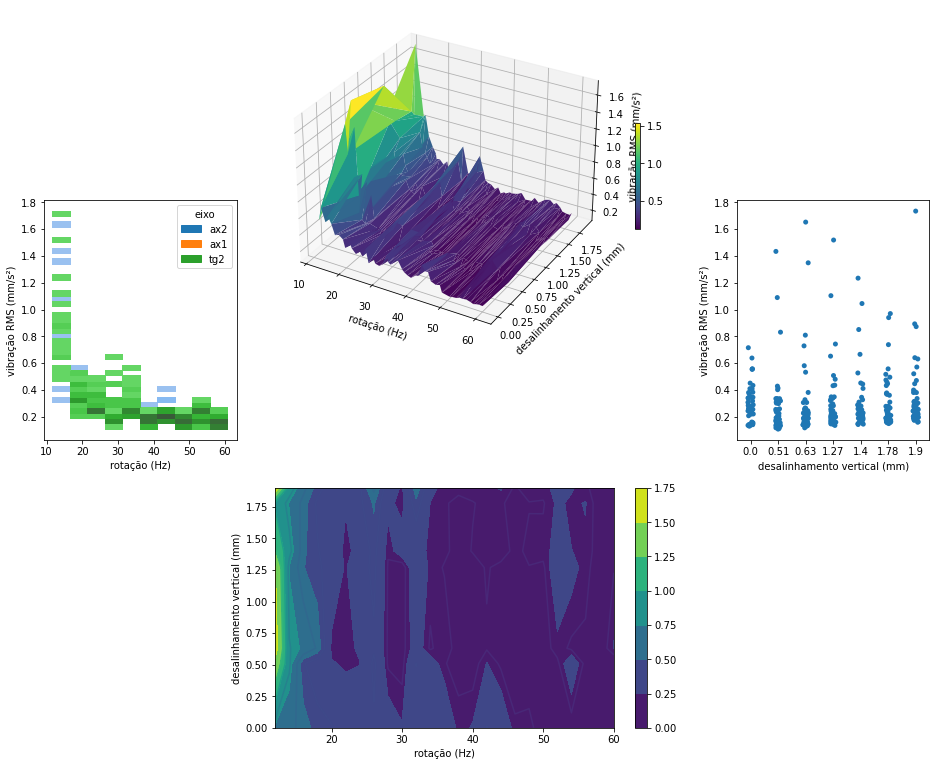

In [10]:
plot_conjunto(df_des_ver_max, DESALINHAMENTO_VERTICAL)

Notamos que a vibração axial acaba ofuscando os demais eixos. Por isso repetiremos a análise para eixos significativos.

### tg2

In [11]:
df_des_ver_max_TG2 = select_max(df_des_ver[['rotacao_calc', 'severidade', 'tg2']])
df_des_ver_max_TG2.rename(columns={'severidade': DESALINHAMENTO_VERTICAL}, inplace=True)

Nível de vibração RMS


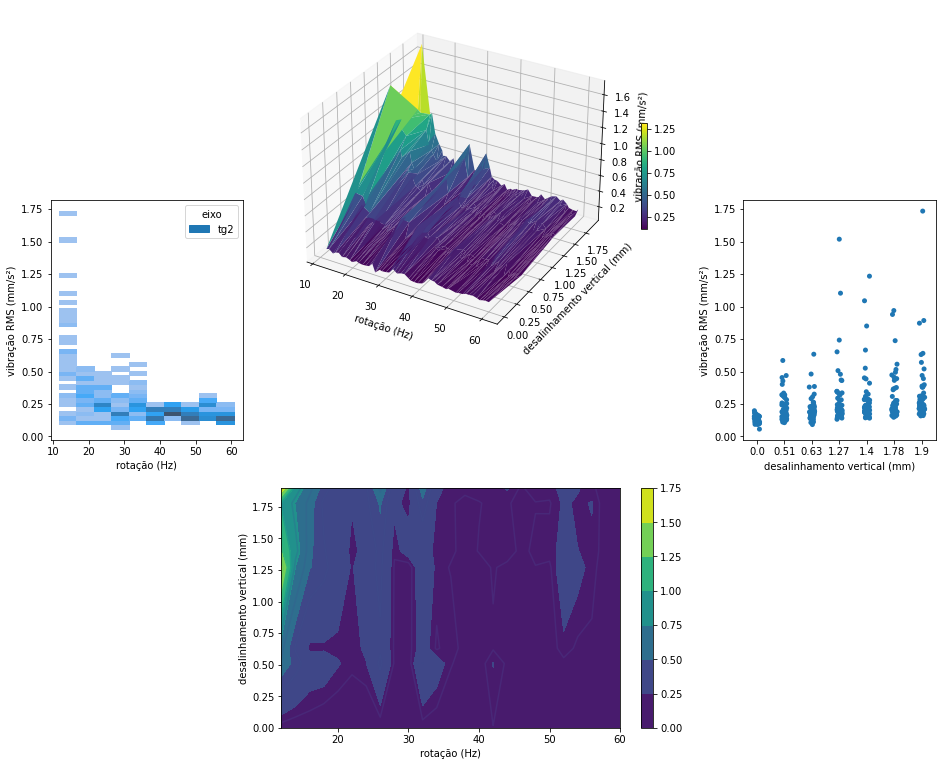

In [12]:
plot_conjunto(df_des_ver_max_TG2, DESALINHAMENTO_VERTICAL)

### Tangente 1

In [13]:
df_des_ver_max_TG1 = select_max(df_des_ver[['rotacao_calc', 'severidade', 'tg1']])
df_des_ver_max_TG1.rename(columns={'severidade': DESALINHAMENTO_VERTICAL}, inplace=True)

Nível de vibração RMS


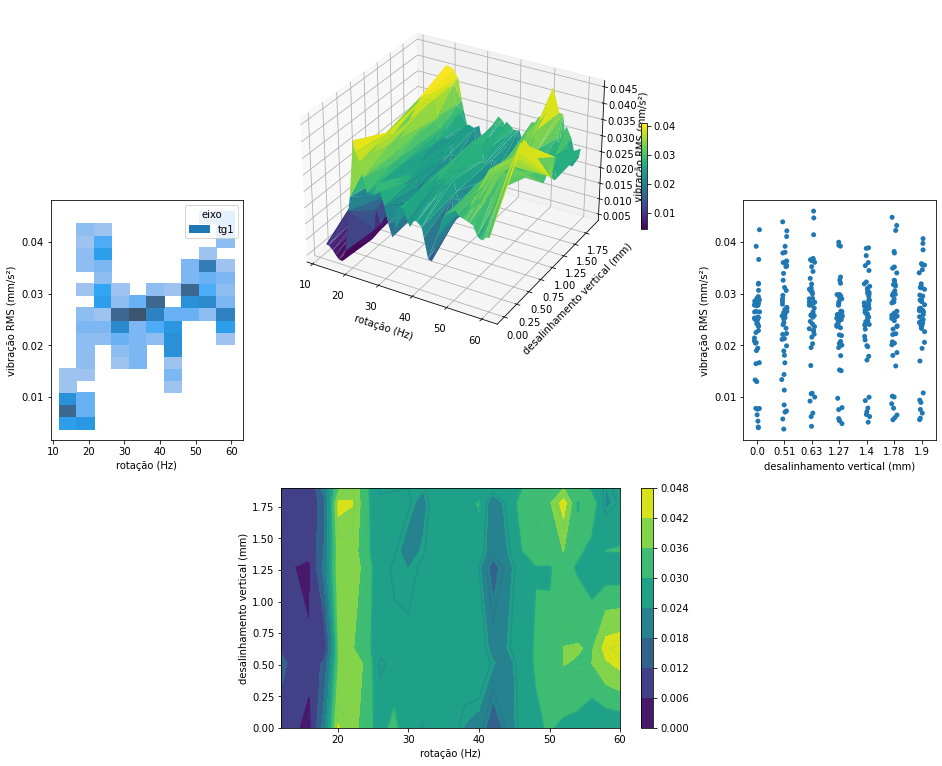

In [14]:
plot_conjunto(df_des_ver_max_TG1, DESALINHAMENTO_VERTICAL)

## Horizontal

In [15]:
df_des_hor = filter_defect(df, 'horizontal-misalignment')
df_des_hor_max = select_max(df_des_hor)

DESALINHAMENTO_HORIZONTAL = 'desalinhamento horizontal (mm)' 
df_des_hor_max.rename(columns={'severidade': DESALINHAMENTO_HORIZONTAL}, inplace=True)
df_des_hor_max

,desalinhamento horizontal (mm),rotação (Hz),eixo,vibração RMS (mm/s²)
0,0.5,12.0,ax2,1.056848
1,0.5,13.2,ax2,0.841957
2,0.5,14.2,ax2,0.795313
3,0.5,15.0,ax2,0.835716
4,0.5,16.0,ax2,0.780123
...,...,...,...,...
875,0.0,56.6,tg2,0.145742
876,0.0,57.4,tg2,0.131640
877,0.0,58.2,tg2,0.141584
878,0.0,59.0,tg2,0.147243


Nível de vibração RMS


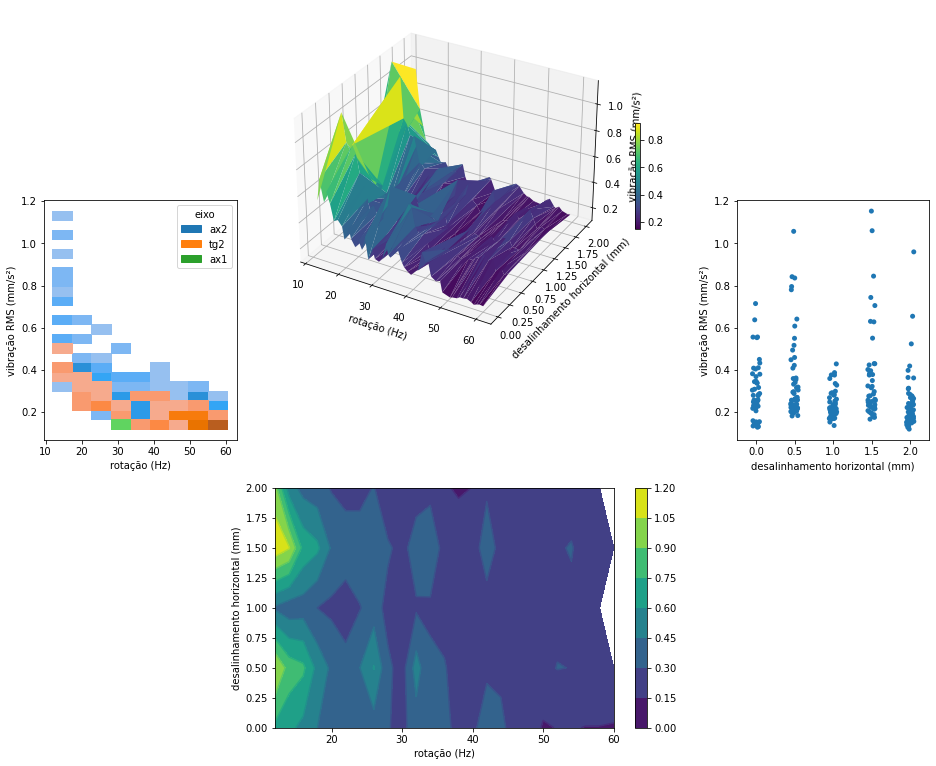

In [16]:
plot_conjunto(df_des_hor_max, DESALINHAMENTO_HORIZONTAL)

# Adequação à norma ABNT NBR 10082

* **Zona A**: valores de vibração recomendados para máquinas novas ou recentemente comissionadas;

* **Zona B**:  consideradas  aceitáveis para operação contínua para longo período de operação, sem restrição;

* **Zona C**:  consideradas insatisfatórias para a operação contínua por um longo período. Geralmente, podem continuar operando por um período limitado de tempo e deve-se programar sua correção;

* **Zona D**: indicam possibilidades de danos em curto prazo

In [17]:
# referência: http://www.brascopper.ind.br/dgq/Sistema%20de%20Gest%C3%A3o%20da%20Qualidade/4%20-%20Contexto%20da%20Organiza%C3%A7%C3%A3o/4.4%20-%20SGQ%20e%20seus%20Processos/Normas/NBR/NBR10082%20-%202011%20-%20Ensaio%20n%C3%A3o%20destrutivo%20-%20An%C3%A1lise%20de%20vibra%C3%A7%C3%B5es.pdf

def zona_NBR10082(valor_eficaz):
    # considerando equipamento Grupo II, suporte flexível
    if valor_eficaz < 2.8:
        return 'A'
    elif valor_eficaz < 4.5:
        return 'B'
    elif valor_eficaz < 7.1:
        return 'C'
    else:
        return 'D'

def zona_ISO10816(valor_eficaz):
    # considerando equipamento classe 1 (máquinas pequenas)
    if valor_eficaz < 1.12:
        return 'A'
    elif valor_eficaz < 2.8:
        return 'B'
    elif valor_eficaz < 7.1:
        return 'C'
    else:
        return 'D'

# definição de cores para cada zona
paleta = {'A':'tab:green', 'B':'tab:olive', 'C':'tab:orange', 'D':'tab:red'}

# indexadores
names = ['Desbalanceamento', 'Desalinhamento vertical', 'Desalinhamento horizontal']
dataframes = [df_desbal_max, df_des_ver_max, df_des_hor_max]

# aplica a norma nos valores RMS
for defect_df in dataframes:
    defect_df['zona'] = defect_df[VALUE].apply(zona_NBR10082)
    defect_df.sort_values('zona', inplace=True, ascending=True)

# reúne dataframes
df_merged = pd.concat(dataframes, keys=names, names=['defeito', 'index']).reset_index()
df_merged.sort_values('zona', inplace=True, ascending=True)

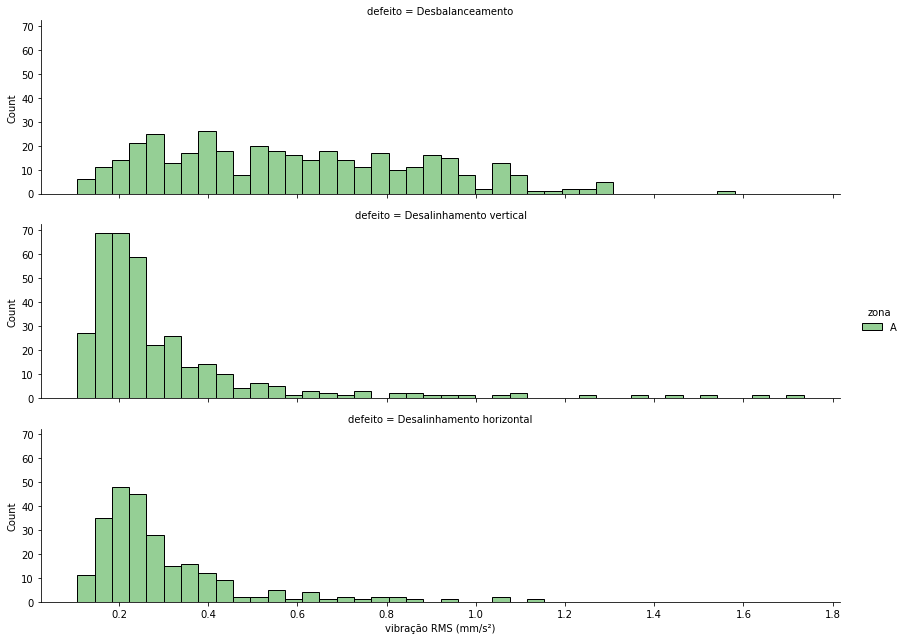

In [18]:
sns.displot(data=df_merged, x=VALUE, hue='zona', palette=paleta, row='defeito', aspect=4, height=3, bins=42);

## Desbalanceamento

In [19]:
sns.relplot(
    data=df_desbal_max, height=4, aspect=1.5,
    y=DESBALANCEAMENTO, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

ValueError: The `sizes` list has the wrong number of values.

In [ ]:
sns.displot(data=df_desbal_max, hue='zona', y=VALUE, x=ROTACAO, palette=paleta);

## Desalinhamento Vertical

In [ ]:
sns.relplot(
    data=df_des_ver_max, height=4, aspect=1.5,
    y=DESALINHAMENTO_VERTICAL, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

In [ ]:
sns.displot(data=df_des_ver_max, hue='zona', y=VALUE, x=ROTACAO, palette=paleta);

## Desalinhamento horizontal

In [ ]:
sns.relplot(
    data=df_des_hor_max, height=4, aspect=1.5,
    y=DESALINHAMENTO_HORIZONTAL, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

In [ ]:
sns.displot(data=df_des_hor_max, hue='zona', y=VALUE, x=ROTACAO, palette=paleta);

# Hipótese de ressonância a ~12 Hz

In [ ]:
# DADOS FORNECIDOS
L = 390e-3   # distância entre mancais (390 mm)
d =  16e-3   # diâmetro do eixo (16 mm)
D = 15.24e-2 # diâmetro do rotor (15.24 cm)


# SUPOSIÇÔES
## espessura do rotor (12 mm)
esp = 12e-3
## eixo e rotor de aço ferramenta (fonte: HIBBELER)
rho = 8.16e3   # densidade (8.16 T/m³)
E = 200e9      # módulo de elasticidade (200 GPa)


## FÓRMULAS
def massa_equivalente(M, m):
    '''Fórmula para viga simplesmente apoiada com massa no meio, onde 
    M = massa do rotor
    m = massa do eixo
    
    fonte: RAO
    '''
    return M + 0.5*m

def mola_equivalente(E, I, L):
    '''Fórmula para viga simplesmente apoiada com carga no meio, onde
    E = módulo de elasticidade
    I = momento de inércia de área da viga
    L = distância entre apoios
    
    fonte: RAO
    '''
    return (48 * E * I) / (L**3)

def momento_de_inercia(r):
    '''Fórmula para viga de seção circular de raio r.

    fonte: HIBBELER
    '''
    return 0.25 * np.pi * r**4



# RESULTADOS
# calcula massa e mola equivalentes
m_eq = massa_equivalente(
    M = np.pi * D**2 * esp /4 * rho,
    m = np.pi * d**2 * L /4 * rho,
)
print('Massa equivalente:\n    {:.3f} kg'.format(m_eq))

k_eq = mola_equivalente(
    E = E, 
    I = momento_de_inercia(r = d/2),
    L = L,
)
print('Mola equivalente:\n    {:.2f} kN/m'.format(k_eq/1000))

# calcula frquência natural do rotor
omega_n = np.sqrt( k_eq / m_eq )
f_n = omega_n / (2*np.pi)

print('\nFrequencia natural:\n    {:.1f} Hz'.format(f_n)) 